# ViT
Curso: [Aprendizaje Profundo](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_profundo/). Profesor: [Gibran Fuentes Pineda](http://turing.iimas.unam.mx/~gibranfp/). Ayudante: [Emilio Morales](https://github.com/milmor).

In [1]:
import torch
import torchvision
import PIL
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import numpy as np

torch.manual_seed(77)
np.random.seed(77)

- Descarga dataset

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [3]:
!unzip -q kagglecatsanddogs_5340.zip

In [4]:
!ls PetImages

Cat  Dog


In [5]:
# Elimina imágenes corruptas
import tensorflow as tf

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [6]:
import pathlib

data_dir = './PetImages/'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('PetImages')

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

23410


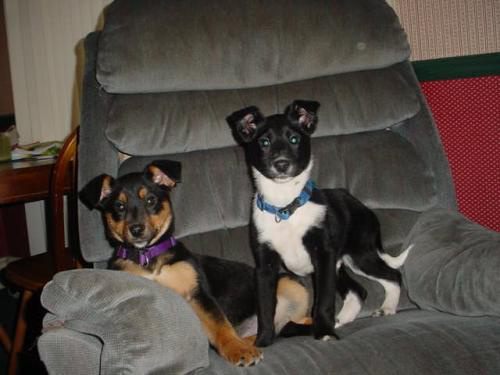

In [8]:
dogs = list(data_dir.glob('Dog/*'))
PIL.Image.open(str(dogs[0]))

## 1.- Pipeline

In [9]:
import torchvision.transforms as T
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import torch.optim as optim
import time

In [10]:
img_size = 128
batch_size = 32

In [11]:
from sklearn.model_selection import train_test_split

dataset = torchvision.datasets.ImageFolder(data_dir)
train_data, test_data, _, _ = train_test_split(dataset.imgs, 
                                               dataset.targets, 
                                               test_size=0.2, 
                                               random_state=42)

class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        image = PIL.Image.open(self.dataset[item][0]).convert('RGB')
        label = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, label
        
        
train_transform = T.Compose([
    T.Resize((img_size, img_size)), 
    T.RandomHorizontalFlip(),
    T.ToTensor(), 
]) 

test_transform = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(), 
]) 

train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=True)

In [12]:
len(train_loader.dataset) 

18728

In [13]:
%%timeit
train_batch, train_labels = next(iter(train_loader))

173 ms ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
train_batch, train_labels = next(iter(train_loader))
train_batch.shape, train_labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [15]:
idx_to_class = {y: x for x, y in dataset.class_to_idx.items()}
idx_to_class

{0: 'Cat', 1: 'Dog'}

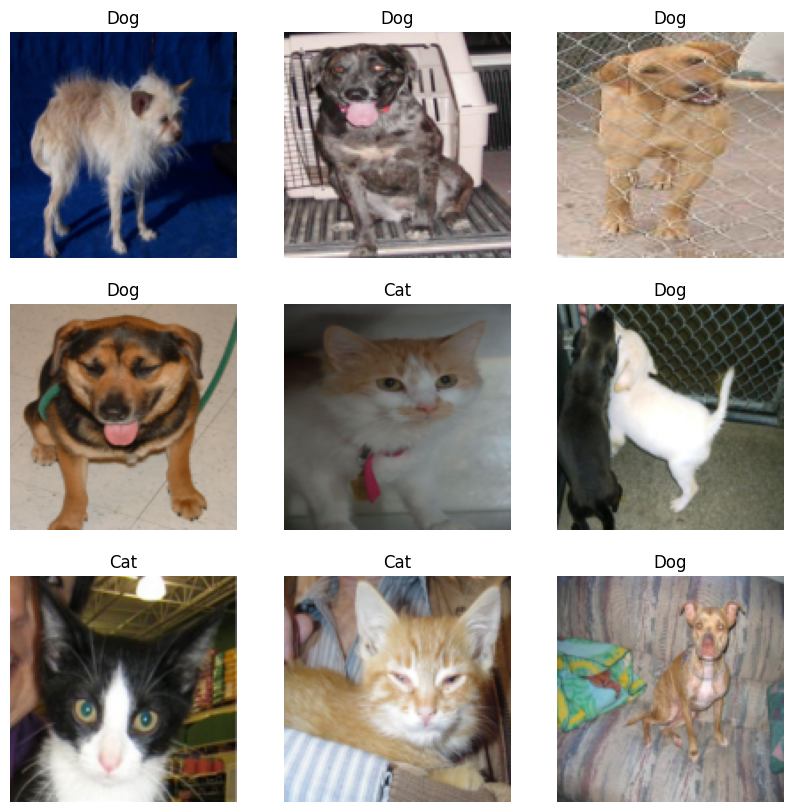

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.transpose(train_batch[i] * 255, [1, 2, 0]).numpy().astype("uint8"))
    plt.title(idx_to_class[int(train_labels[i].numpy())])
    plt.axis("off")

## 2.- Modelo
- Definir auto atención producto punto

\begin{equation}
\mbox{MultiHead}(Q, K, V) = \text{Concat}(\mbox{head}_1,\mbox{head}_2,\ldots,\mbox{head}_h)W^O,
\end{equation}

\begin{equation}
\mbox{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) = \text{softmax}\left[\frac{QW_i^Q(KW_i^K)^T}{\sqrt{d_k}}\right]VW_i^V,
\end{equation}


In [17]:
class Attention(nn.Module):
    def __init__(self, dim, n_heads, bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        self.qw = nn.Linear(dim, dim, bias = bias)
        self.kw = nn.Linear(dim, dim, bias = bias)
        self.vw = nn.Linear(dim, dim, bias = bias)

        self.ow = nn.Linear(dim, dim, bias = bias)

    def forward(self, x):
        q = self.qw(x)
        k = self.qw(x)
        v = self.qw(x)

        B, L, D = q.shape
        q = torch.reshape(q, [B, L, self.n_heads, -1])
        q = torch.permute(q, [0, 2, 1, 3])
        k = torch.reshape(k, [B, L, self.n_heads, -1])
        k = torch.permute(k, [0, 2, 3, 1])
        v = torch.reshape(v, [B, L, self.n_heads, -1])
        v = torch.permute(v, [0, 2, 1, 3])

        qk = torch.matmul(q, k) * self.scale
        attn = F.softmax(qk, dim=-1)
        v_attn = torch.matmul(attn, v)
        v_attn = torch.permute(v_attn, [0, 2, 1, 3])
        v_attn = torch.reshape(v_attn, [B, L, D])

        x = self.ow(v_attn)
        return x

test_layer = Attention(32, 2)
test_layer(torch.ones([1, 256, 32])).shape

torch.Size([1, 256, 32])

- Definir ViT:

\begin{align}
    \mathbb{h}_0 &= [ \mathbb{x}_\text{class}, \, \mathbb{x}_1 E, \ldots, \, \mathbb{x}_N E ] + E_{pos},
    &&  E_{pos}  \in \mathbb{R}^{(N + 1) \times D} \\
    \mathbb{h}^\prime_\ell &= \text{MSA}(\text{LN}(\mathbb{h}_{\ell-1})) + \mathbb{h}_{\ell-1}, && \ell=1,\ldots,L \\
    \mathbb{h}_\ell &= \text{MLP}(\text{LN}(\mathbb{h}^\prime_{\ell})) + \mathbb{h}^\prime_{\ell}, && \ell=1,\ldots,L   \\
    \mathbb{y} &= \text{LN}(\mathbb{h}_L^0)
\end{align}

In [18]:
class Transformer(nn.Module):
    def __init__(self, dim, heads, mlp_dim, rate=0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads)
        self.ln_2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(rate),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(rate),
        )

    def forward(self, x):
        x = self.attn(self.ln_1(x)) + x
        return self.mlp(self.ln_2(x)) + x

test_layer = Transformer(64, 2, 256)
test_layer(torch.ones([1, 64, 64])).shape

torch.Size([1, 64, 64])

In [19]:
summary(test_layer, (64, 64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1               [-1, 64, 64]             128
            Linear-2               [-1, 64, 64]           4,160
            Linear-3               [-1, 64, 64]           4,160
            Linear-4               [-1, 64, 64]           4,160
            Linear-5               [-1, 64, 64]           4,160
         Attention-6               [-1, 64, 64]               0
         LayerNorm-7               [-1, 64, 64]             128
            Linear-8              [-1, 64, 256]          16,640
              GELU-9              [-1, 64, 256]               0
          Dropout-10              [-1, 64, 256]               0
           Linear-11               [-1, 64, 64]          16,448
          Dropout-12               [-1, 64, 64]               0
Total params: 49,984
Trainable params: 49,984
Non-trainable params: 0
---------------------------------

![CiT](https://raw.githubusercontent.com/lucidrains/vit-pytorch/main/images/vit.gif)

- _Imagen de https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif_

In [20]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, out_dim, dim, 
                 depth, heads, mlp_dim, rate=0.0):
        super().__init__()
        self.dim = dim
        self.n_patches = (img_size // patch_size)**2
        
        self.patches = nn.Conv2d(3, dim, patch_size, 
                                 stride=patch_size, padding=0)

        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.transformer = nn.Sequential()
        for _ in range(depth):
            self.transformer.append(Transformer(dim, heads, mlp_dim))

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patches(x)

        x = torch.permute(x, [0, 2, 3, 1])
        x = torch.reshape(x, [B, self.n_patches, self.dim])

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embedding

        x = self.transformer(x)
        x = x[:, 0]
        return self.mlp_head(x)   


patch_size = 16
out_dim = 1
model_dim = 64
depth = 3
heads = 4
mlp_dim = 64
dropout = 0.5

vit = ViT(img_size, patch_size, out_dim, 
          model_dim, depth, heads, mlp_dim, dropout)
test_out = vit(train_batch)
test_out.shape

torch.Size([32, 1])

In [21]:
summary(vit, (3, img_size, img_size), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]          49,216
         LayerNorm-2               [-1, 65, 64]             128
            Linear-3               [-1, 65, 64]           4,160
            Linear-4               [-1, 65, 64]           4,160
            Linear-5               [-1, 65, 64]           4,160
            Linear-6               [-1, 65, 64]           4,160
         Attention-7               [-1, 65, 64]               0
         LayerNorm-8               [-1, 65, 64]             128
            Linear-9               [-1, 65, 64]           4,160
             GELU-10               [-1, 65, 64]               0
          Dropout-11               [-1, 65, 64]               0
           Linear-12               [-1, 65, 64]           4,160
          Dropout-13               [-1, 65, 64]               0
      Transformer-14               [-1,

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [23]:
vit.to(device)

ViT(
  (patches): Conv2d(3, 64, kernel_size=(16, 16), stride=(16, 16))
  (transformer): Sequential(
    (0): Transformer(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qw): Linear(in_features=64, out_features=64, bias=True)
        (kw): Linear(in_features=64, out_features=64, bias=True)
        (vw): Linear(in_features=64, out_features=64, bias=True)
        (ow): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=64, out_features=64, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Transformer(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qw): Linear(in_features=64, out_featu

## 3.- Entrenamiento

In [24]:
optimizer = optim.Adam(vit.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

In [25]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        # data is a list of [inputs, labels]
        labels = labels.reshape(-1, 1).to(torch.float32)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:4f} sec Train loss: {running_loss / len(train_loader):4f}')

In [26]:
def test(model, device, test_loader):
    start = time.time()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            # data is a list of [inputs, labels]
            labels = labels.reshape(-1, 1).to(torch.float32)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            outputs = torch.round(outputs)
            running_acc += outputs.eq(labels.view_as(outputs)).sum().item()
            running_loss += loss.item()

    print(f'Time for eval is {time.time()-start:4f} sec Val loss: {running_loss / len(test_loader):4f}')
    print(f'Val acc: {running_acc / len(test_loader.dataset):4f}')

In [27]:
epochs = 25

for epoch in range(epochs):
    train(vit, device, train_loader, optimizer, epoch)
    test(vit, device, test_loader)

print('Finished Training')


Time for epoch 0 is 20.803231 sec Train loss: 0.686495
Time for eval is 4.859090 sec Val loss: 0.683314
Val acc: 0.561939

Time for epoch 1 is 19.822719 sec Train loss: 0.672589
Time for eval is 4.785132 sec Val loss: 0.662134
Val acc: 0.606151

Time for epoch 2 is 19.478010 sec Train loss: 0.654307
Time for eval is 4.763949 sec Val loss: 0.639254
Val acc: 0.619821

Time for epoch 3 is 19.896268 sec Train loss: 0.631058
Time for eval is 4.920185 sec Val loss: 0.619228
Val acc: 0.639684

Time for epoch 4 is 19.623896 sec Train loss: 0.612131
Time for eval is 4.870387 sec Val loss: 0.602895
Val acc: 0.661897

Time for epoch 5 is 19.497030 sec Train loss: 0.591884
Time for eval is 4.808300 sec Val loss: 0.600101
Val acc: 0.660615

Time for epoch 6 is 19.256823 sec Train loss: 0.574705
Time for eval is 4.772892 sec Val loss: 0.572296
Val acc: 0.694789

Time for epoch 7 is 19.437459 sec Train loss: 0.558852
Time for eval is 4.775752 sec Val loss: 0.573403
Val acc: 0.698419

Time for epoch 

- Predicciones del modelo

In [28]:
test_batch, test_labels = next(iter(test_loader))

In [29]:
device = torch.device('cpu')
vit.to(device)
vit.eval()
test_batch = test_batch.to(device)
pred = vit(test_batch)

In [30]:
pred = torch.round(pred).reshape(-1)
pred.shape, test_labels

(torch.Size([32]),
 tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
         0, 0, 1, 0, 0, 1, 0, 0]))

In [31]:
pred

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       grad_fn=<ReshapeAliasBackward0>)

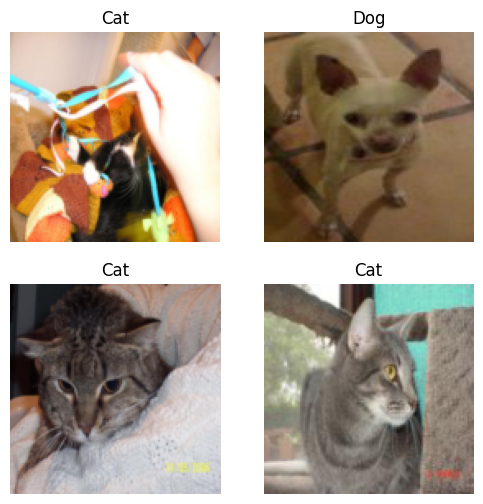

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 6))

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(np.transpose(test_batch[i] * 255, [1, 2, 0]).numpy().astype("uint8"))
    plt.title(idx_to_class[int(pred[i])])
    plt.axis("off")